In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

from IPython.display import display, Audio

In [3]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [4]:
fs, x = sp.io.wavfile.read('x.wav')  # 'rendered_audio/tp_-60_cough_+30.wav'  #'binaural_simulated.wav'
x = x.T
x = x[:, :fs*5]  # at most 5 seconds
if fs != 16000:
    x = sp.signal.resample(x, 16000 * x.shape[1] // fs, axis=1)
    fs = 16000
display(Audio(x, rate=fs))

In [5]:
from duet_orig import DuetOrig

In [17]:
duet = DuetOrig(
    fs,
    attenuation_max=3.5, n_attenuation_bins=175,
    delay_max=3.6, n_delay_bins=50,
    height=1e10
)
xx = duet._normalize_data(x)
tf, tf_weights, alpha, delta = duet._compute_all(xx)
hist = duet._compute_hist(tf_weights, alpha, delta)
sym_atn_peaks, delay_peaks = duet._find_hist_peaks(hist)
atn_peaks = duet._convert_sym_to_atn(sym_atn_peaks)
best, sources = duet._compute_sources(tf, atn_peaks, delay_peaks)
sources = duet._demix(best, sources)
est = duet._convert_to_time_domain(sources, end=x.shape[1])

ValueError: attempt to get argmin of an empty sequence

In [20]:
atn_peaks

array([], dtype=float64)

In [8]:
def hist_delays(x, delays):
    tiled_hist = np.zeros((len(delays), duet.n_attenuation_bins, duet.n_delay_bins))
    for i, delay in enumerate(delays):
        xx = np.stack((
            x[0, delay:],
            x[1, :-delay],
        ), axis=0) if delay != 0 else x
        tf, tf_weights, alpha, delta = duet._compute_all(xx)
        hist = duet._compute_hist(tf_weights, alpha, delta)
        tiled_hist[i] = hist
    return tiled_hist.sum(axis=0)

In [10]:
a, d

(array([-3.5       , -3.41954023, -3.37931034, -3.33908046, -3.33908046,
        -3.29885057, -3.09770115, -3.01724138, -2.89655172, -2.77586207,
        -2.73563218, -2.73563218, -2.6954023 , -2.53448276, -2.49425287,
        -2.45402299, -2.09195402, -1.97126437, -1.85057471, -1.77011494,
        -1.77011494, -1.48850575, -1.40804598, -1.12643678, -0.92528736,
        -0.24137931,  0.12068966,  0.40229885,  0.40229885,  0.44252874,
         0.44252874,  0.76436782,  1.00574713,  1.00574713,  1.12643678,
         1.32758621,  1.81034483,  1.8908046 ,  2.05172414,  2.13218391,
         2.17241379,  2.45402299,  2.45402299,  2.65517241,  2.73563218,
         2.81609195,  2.89655172,  2.97701149,  3.01724138,  3.09770115,
         3.17816092,  3.37931034,  3.41954023,  3.45977011,  3.5       ]),
 array([-1.54285714, -3.30612245,  0.66122449, -0.07346939,  2.86530612,
        -1.24897959, -2.4244898 ,  2.71836735, -0.36734694, -1.83673469,
        -3.30612245,  1.68979592,  3.6       , -0

In [14]:
duet.n_attenuation_bins, duet.n_delay_bins

(175, 50)

In [15]:
a, d

(array([  0.,   2.,   3.,   4.,   4.,   5.,  10.,  12.,  15.,  18.,  19.,
         19.,  20.,  24.,  25.,  26.,  35.,  38.,  41.,  43.,  43.,  50.,
         52.,  59.,  64.,  81.,  90.,  97.,  97.,  98.,  98., 106., 112.,
        112., 115., 120., 132., 134., 138., 140., 141., 148., 148., 153.,
        155., 157., 159., 161., 162., 164., 166., 171., 172., 173., 174.]),
 array([14.,  2., 29., 24., 44., 16.,  8., 43., 22., 12.,  2., 36., 49.,
        21., 38., 32., 45., 20., 27., 14., 35., 40., 29., 21.,  7., 28.,
        33.,  3., 14., 33., 49., 34.,  7., 20., 28., 42.,  0., 25.,  2.,
        33., 47.,  8., 15., 22., 38., 26., 11., 44., 17.,  4., 35., 49.,
        42.,  2., 12.]))

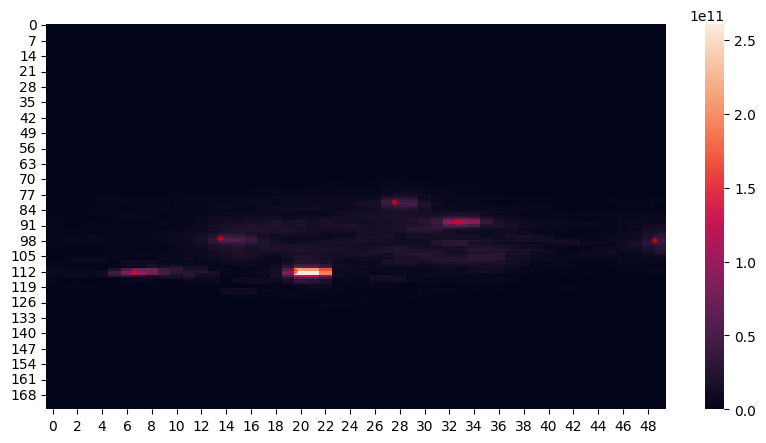

In [19]:
tiled_hist = hist_delays(x, [0, 5, 10, 15]) // 4
a, d = duet._find_hist_peaks(tiled_hist)
a = (a + duet.attenuation_max) * (duet.n_attenuation_bins - 1) / (2 * duet.attenuation_max)
d = (d + duet.delay_max) * (duet.n_delay_bins - 1) / (2 * duet.delay_max)
plt.figure(figsize=(10, 5))
sns.heatmap(tiled_hist)
plt.scatter(
    d,
    a,
    c='red',
    s=10,
    alpha=0.5,
)

In [58]:
def plot_with_delay(x, delay):  # actually doubles the delay, delay is in samples
    x = np.stack((
        x[0, delay:],
        x[1, :-delay],
    ), axis=0) if delay != 0 else x
    tf, tf_weights, alpha, delta = duet._compute_all(x)
    tf_weights_log = np.log(tf_weights)
    tf_weights_log = tf_weights_log - np.min(tf_weights_log)
    tf_weights_log = tf_weights_log / (5*np.max(tf_weights_log))
    hist = duet._compute_hist(tf_weights, alpha, delta)
    plt.subplot(1, 2, 1)
    plt.title(f"Delay: {delay}")
    plt.scatter(alpha, delta, alpha=tf_weights_log, s=0.1)
    plt.xlim(-3.6, 3.6)
    plt.ylim(-3.6, 3.6)
    plt.subplot(1, 2, 2)
    sns.heatmap(hist)

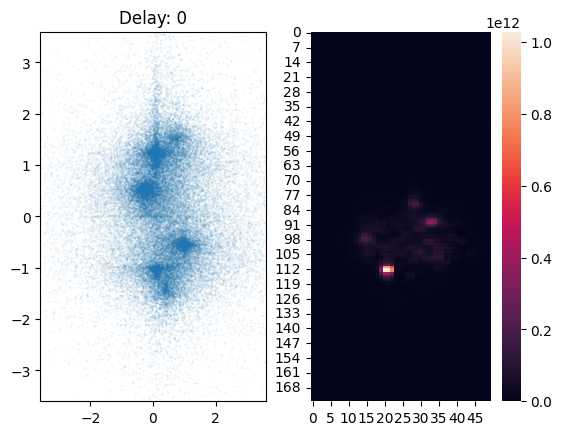

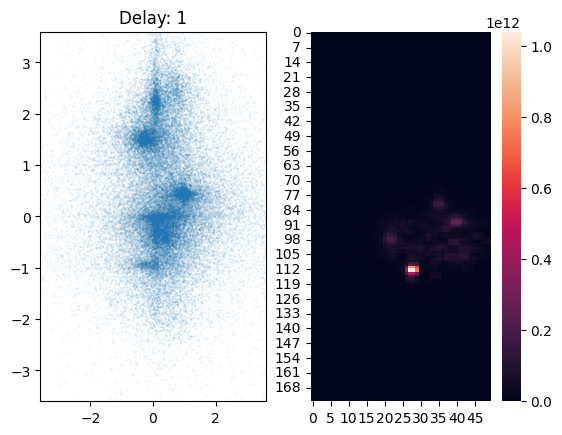

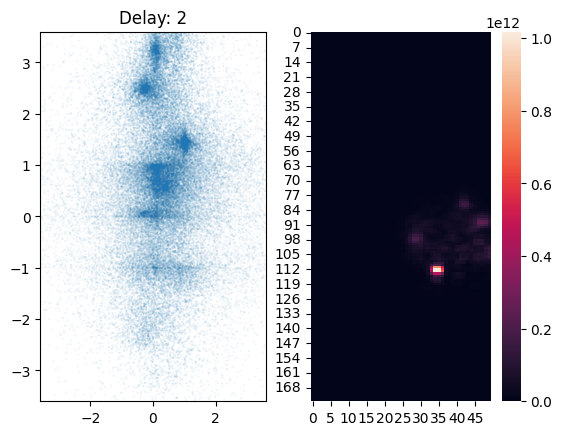

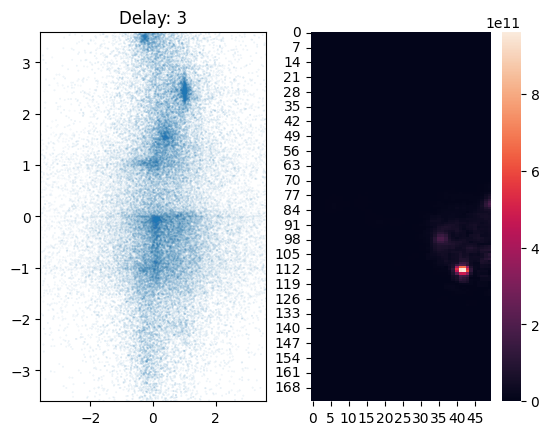

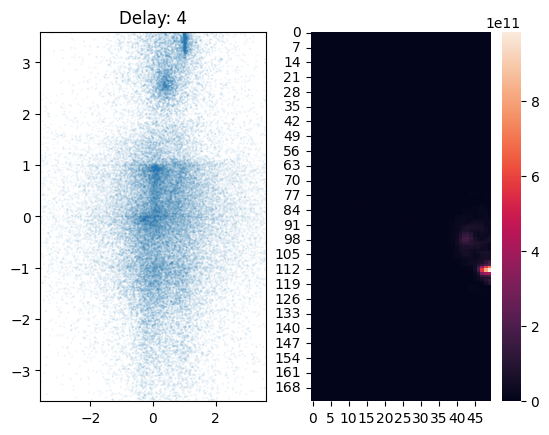

In [59]:
plt.figure()
plot_with_delay(x, 0)
plt.figure()
plot_with_delay(x, 1)
plt.figure()
plot_with_delay(x, 2)
plt.figure()
plot_with_delay(x, 3)
plt.figure()
plot_with_delay(x, 4)

In [9]:
%timeit duet.run(x);

49.4 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%lprun  -f duet.run -f duet._compute_all -f duet._demix duet.run(x);

Timer unit: 1e-09 s

Total time: 0.122516 s
File: /home/jbush/HONORS/duet_base.py
Function: run at line 116

Line #      Hits         Time  Per Hit   % Time  Line Contents
   116                                               def run(self, x: ndarray) -> ndarray:
   117                                                   """
   118                                                   Run the DUET algorithm on the input audio signal. This is the
   119                                                   "offline" version of the algorithm, which processes the entire input
   120                                                   signal.
   121                                           
   122                                                   Arguments
   123                                                   ---------
   124                                                   x : ndarray
   125                                                       The input audio signal, has shape (n_channels, n_sam

((128, 513), (128, 513), (2, 128, 513), (128, 513), 0.008, 62.5)

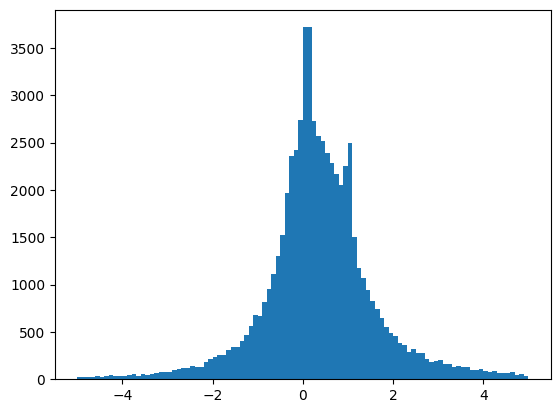

In [12]:
tf_mag = np.abs(tf[0])*np.abs(tf[1])
np.savetxt('alpha-delta.csv', np.stack((alpha.ravel(), delta.ravel())), delimiter=',')
np.savetxt('weights.csv', tf_mag.ravel(), delimiter=',')

plt.hist(alpha[abs(alpha) < 5], bins=100);
alpha.shape, delta.shape, tf.shape, tf_mag.shape, duet.stft.delta_t, duet.stft.delta_f  # 1023 (~513*2) different frequencies, 129 times

<Axes: >

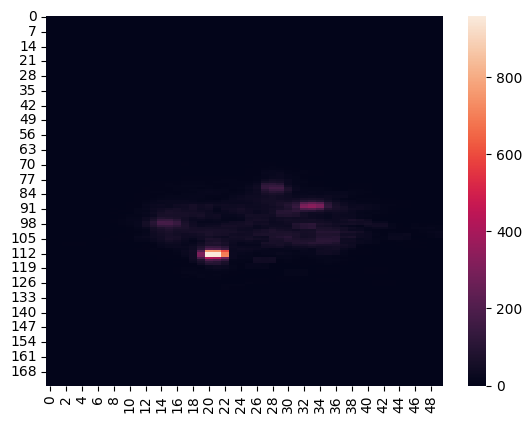

In [13]:
sns.heatmap(hist)

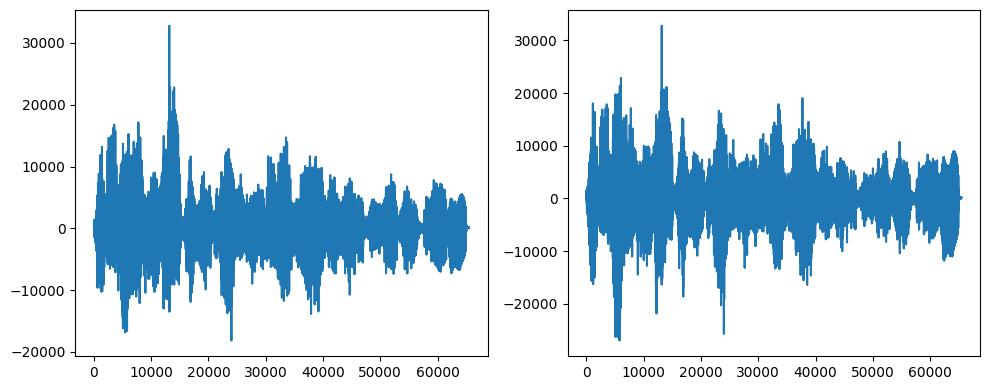

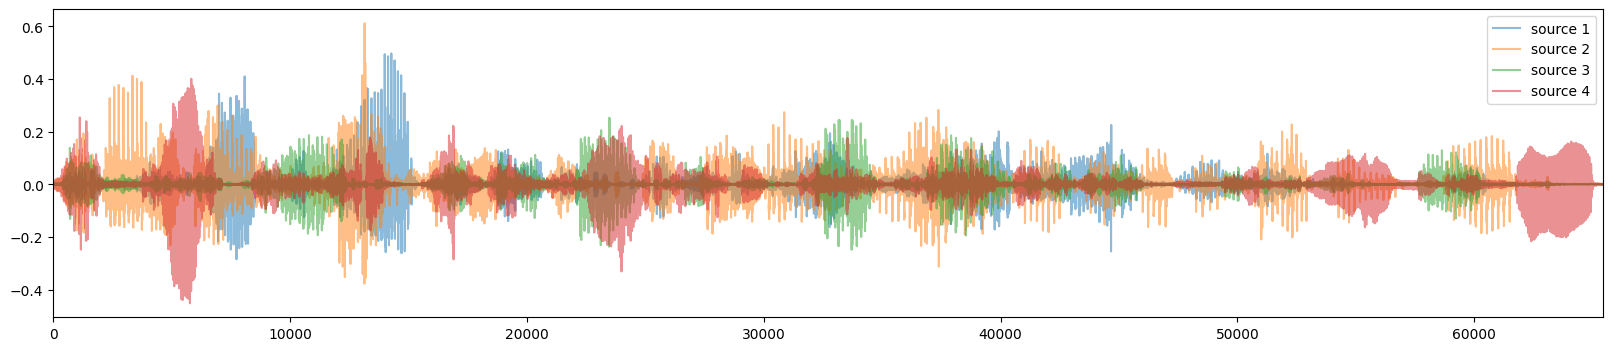

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x[0])
plt.subplot(1, 2, 2)
plt.plot(x[1])
plt.tight_layout()
#display(Audio(x, rate=fs))

plt.figure(figsize=(20, 4))
for i in range(len(est)):
    plt.plot(est[i], alpha=0.5, label=f'source {i+1}')
    display(Audio(est[i], rate=fs))
plt.xlim(0, est.shape[1])
plt.legend();

In [15]:
from BSS_DUET.bss import Duet

In [16]:
bss_duet = Duet(x, n_sources=5, sample_rate=fs)
estimates = bss_duet()
%timeit bss_duet()

106 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
for i in range(len(estimates)):
    display(Audio(estimates[i]+0.01*xx[0], rate=fs))
    #sp.io.wavfile.write(f"output{i}.wav", fs, estimates[i]+0.01*xx[0])

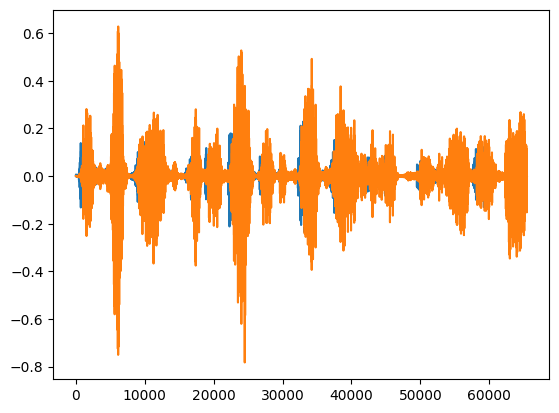

In [21]:
plt.plot(est[2])
plt.plot(estimates[1])

In [22]:
-1j * 2

-2j